In [5]:
import sys
sys.path.append('../')

import copy
import glob

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

import torch
import torch.nn as nn

import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx

from src.utils import *
from dataset import *
# from src.train import train, test
from src.scalers import StandardScaler as Scaler
from src.dataloaders import make_dataloaders_from_dataset, make_dataloaders_from_datasets
from src.model import BaseEstimator

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [38]:
G = nx.readwrite.read_gpickle('data/network64.gpickle')

In [39]:
# Pytorch geometric Data object. For now used only for storing node embedding. 
# Supposed to be used in the future for obtaining node embeddings.
node_attrs = list(next(iter(G.nodes(data=True)))[-1].keys())
# node_attrs[3:]
pyg_graph = from_networkx(G, group_node_attrs=node_attrs[3:-1])
pyg_graph.to(device)
print(node_attrs[3:-1])

['labor_force_rate', 'housing_sales_num_Total:', 'housing_sales_num_Total:!!Less than $10,000', 'housing_sales_num_Total:!!$10,000 to $14,999', 'housing_sales_num_Total:!!$15,000 to $19,999', 'housing_sales_num_Total:!!$20,000 to $24,999', 'housing_sales_num_Total:!!$25,000 to $29,999', 'housing_sales_num_Total:!!$30,000 to $34,999', 'housing_sales_num_Total:!!$35,000 to $39,999', 'housing_sales_num_Total:!!$40,000 to $49,999', 'housing_sales_num_Total:!!$50,000 to $59,999', 'housing_sales_num_Total:!!$60,000 to $69,999', 'housing_sales_num_Total:!!$70,000 to $79,999', 'housing_sales_num_Total:!!$80,000 to $89,999', 'housing_sales_num_Total:!!$90,000 to $99,999', 'housing_sales_num_Total:!!$100,000 to $124,999', 'housing_sales_num_Total:!!$125,000 to $149,999', 'housing_sales_num_Total:!!$150,000 to $174,999', 'housing_sales_num_Total:!!$175,000 to $199,999', 'housing_sales_num_Total:!!$200,000 to $249,999', 'housing_sales_num_Total:!!$250,000 to $299,999', 'housing_sales_num_Total:!!$

In [40]:
pyg_graph.x = Scaler().fit_transform(pyg_graph.x)

In [41]:
class DoubleStationDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        x1, y1 = self.dataset[index // len(self.dataset)]
        x2, y2 = self.dataset[index % len(self.dataset)]

        return x1, y1, x2, y2

    def __len__(self):
        return len(self.dataset) ** 2

In [42]:
from sklearn.metrics import r2_score

def test(model, loader, loss_fn, device):
    """ returns average loss and score
    """
    model.eval()

    total_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for (X1, y1, X2, y2) in loader:
            y1, y2 = y1 + 1, y2 + 1
            y1_gpu, y2_gpu = y1.to(device), y2.to(device)
            out = model(X1, X2)

            loss = loss_fn(out, y1_gpu / y2_gpu)
            total_loss += loss.item()

            y_true.extend(y1 / y2)
            y_pred.extend(out.detach().cpu())
    
    return total_loss / len(loader), r2_score(y_true, y_pred)


def train(model, train_loader, val_loader, loss_fn,
          optimizer, device, scheduler=None, num_epochs=10, plotting=True):
    """ returns best model on validation
    """
    train_losses = []
    val_losses = []
    val_scores = []
    train_scores = []
    
    best_val_score = -torch.inf
    best_model = None

    for epoch in range(num_epochs + 1):
        model.train()
        total_loss = 0

        for i_step, (X1, y1, X2, y2) in enumerate(train_loader):
            optimizer.zero_grad()
            # y1, y2 = np.log1p(y1), np.log1p(y2)
            y1, y2 = y1 + 1, y2 + 1
            y1_gpu, y2_gpu = y1.float().to(device), y2.float().to(device)

            out = model(X1, X2)
            loss = loss_fn(out, y1_gpu / y2_gpu)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        if scheduler is not None:
            scheduler.step()

        _, train_score = test(model, train_loader, loss_fn, device)
        val_loss, val_score = test(model, val_loader, loss_fn, device)

        if epoch > 2:
            val_losses.append(val_loss)
            val_scores.append(val_score)
            train_scores.append(train_score)

        # if val_score > best_val_score:
        #     best_val_score = val_score
        #     best_model = copy.deepcopy(model)

        if plotting and epoch > 2 and epoch % 2 == 0:
            clear_output(True)
            _, axes = plt.subplots(1, 2, figsize=(20, 6))
            
            sns.lineplot(ax=axes[0], x=range(len(train_losses)), y=train_losses, label='Train', color='blue')
            sns.lineplot(ax=axes[0], x=range(len(val_losses)), y=val_losses, label='Val', color='red')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()

            sns.lineplot(ax=axes[1], x=range(len(val_scores)), y=val_scores, label='Val', color='red')
            sns.lineplot(ax=axes[1], x=range(len(train_scores)), y=train_scores, label='Train', color='blue')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Score')
            axes[1].legend()

            plt.show()
            # print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Val loss: {val_loss:.4f}, Val R2: {val_scores[-1]:.4f}')
        
    return model

In [43]:
class LocationScaler(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim),
            nn.ReLU(),

            # nn.Dropout(0.5),

            nn.Linear(self.hidden_dim, 1),
            # nn.ReLU()
        )

    def forward(self, X):
        out = self.layers(X)
        # out = torch.exp(out)
        return out


class Estimator(BaseEstimator):
    def __init__(self, pyg_graph: pyg.data.Data, obs_nodes, obs_targets) -> None:
        super().__init__(pyg_graph, obs_nodes, obs_targets)

        self.loc_scaler = LocationScaler(self.g.x.shape[-1])
    
    def forward(self, loc_a, loc_b):
        loc_a_indices = torch.as_tensor(self.node_to_idx(loc_a)).to(device)
        loc_b_indices = torch.as_tensor(self.node_to_idx(loc_b)).to(device)

        loc_a_emb, loc_b_emb = self.g.x[loc_a_indices], self.g.x[loc_b_indices]
        

        out = self.loc_scaler(loc_a_emb) / self.loc_scaler(loc_b_emb)
        # out = torch.exp(out)

        # print(self.loc_scaler(loc_b_emb))
        
        return out.reshape(-1)


In [44]:
def make_datasets(ds):
    remain = len(ds)
    train = int(remain * 0.7)
    remain -= train
    val = int(remain * 0.5)
    remain -= val
    test = remain
    return map(lambda x : DoubleStationDataset(x), torch.utils.data.random_split(ds, [train, val, test]))

In [45]:
kek = [*make_datasets(ds)][2]

In [46]:
train_loader, val_loader, test_loader = make_dataloaders_from_datasets(*make_datasets(ds), batch_size=4)
for i, k in enumerate(train_loader):
    if i == 3:
        break
    print(k)

[('36 ST', 'FLUSHING AV', 'CORTLANDT ST', '88 ST'), tensor([1401.8654,  856.3984,  118.7363,  472.9451], dtype=torch.float64), ('HALSEY ST', '88 ST', 'WILSON AV', '88 ST'), tensor([949.0714, 472.9451, 495.6621, 472.9451], dtype=torch.float64)]
[('BEVERLY RD', '157 ST', 'CORTELYOU RD', 'PROSPECT AV'), tensor([ 724.8159,  521.0357,  961.1703, 1474.0247], dtype=torch.float64), ('HALSEY ST', 'BURKE AV', 'CORTLANDT ST', 'BURKE AV'), tensor([949.0714, 583.1401, 118.7363, 583.1401], dtype=torch.float64)]
[('BURKE AV', 'MORGAN AV', 'ST LAWRENCE AV', 'CYPRESS AV'), tensor([583.1401, 636.9313, 320.1731, 483.9341], dtype=torch.float64), ('72 ST', 'NOSTRAND AV', 'BROAD ST', 'WOODLAWN'), tensor([1009.9505, 1106.8516,  341.1593,  736.6896], dtype=torch.float64)]


In [47]:
import datetime
# loss_fn = nn.HuberLoss(delta=50).to(device)
loss_fn = nn.MSELoss().to(device)
# model = None

for path in tqdm(glob.glob('datasets/*')[:]):
    try:
        day = path.split('/')[1].split('.')[0]
        day_num = datetime.datetime.strptime(day, '%Y-%m-%d').weekday()
        workday = day_num < 5
        
        if not (workday and datetime.datetime.strptime('2021-01-04', '%Y-%m-%d').weekday() < 5):
            continue
    except:
        continue

    try:
        ds = torch.load(path)
    except:
        print('ds not found')
        
    train_loader, val_loader, test_loader = make_dataloaders_from_datasets(*make_datasets(ds), batch_size=64)
    train_batches = [batch for batch in train_loader]
    train_nodes = [n for batch in train_batches for n in batch[0]]
    train_targets = torch.cat([batch[1] for batch in train_batches])
        
    if model is None:
        model = Estimator(pyg_graph, train_nodes, train_targets).to(device)
    else:
        model.set_observations(train_nodes, train_targets)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    test_loss, test_score = test(model, test_loader, loss_fn, device)

    # for name, param in best_model.named_parameters():
        # print(name, param)

    print(f'{day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

    # model = train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=40, plotting=False)
    # test_loss, test_score = test(model, test_loader, loss_fn, device)
    # print(f'{day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

  0%|          | 0/31 [00:00<?, ?it/s]

2021-01-15, Test loss: 531.4547, test score: -5.5912
2021-01-04, Test loss: 734.1809, test score: -67.1430
2020-12-28, Test loss: 31872.5522, test score: -0.0781
2021-01-06, Test loss: 31699.8496, test score: -0.0547
2021-01-13, Test loss: 3004.7216, test score: -0.1763
2021-01-20, Test loss: 9876.8680, test score: -0.0589
2021-01-18, Test loss: 6961.2052, test score: -0.0411
2021-01-12, Test loss: 23507.1567, test score: -0.0344
2020-12-29, Test loss: 11632.9187, test score: -0.0372
2021-01-07, Test loss: 15076.1999, test score: -0.0573
2020-12-30, Test loss: 48.7117, test score: -4.4486
2021-01-19, Test loss: 9674.2138, test score: 0.0450
2021-01-05, Test loss: 9720.0597, test score: -0.0256
2020-12-31, Test loss: 96.2879, test score: -7.4503
2021-01-22, Test loss: 17236.1744, test score: -0.0047
2021-01-21, Test loss: 31393.4317, test score: -0.0477
2021-01-08, Test loss: 37.9609, test score: -0.5931
2021-01-01, Test loss: 2159.5873, test score: -0.2077
2021-01-11, Test loss: 10.560

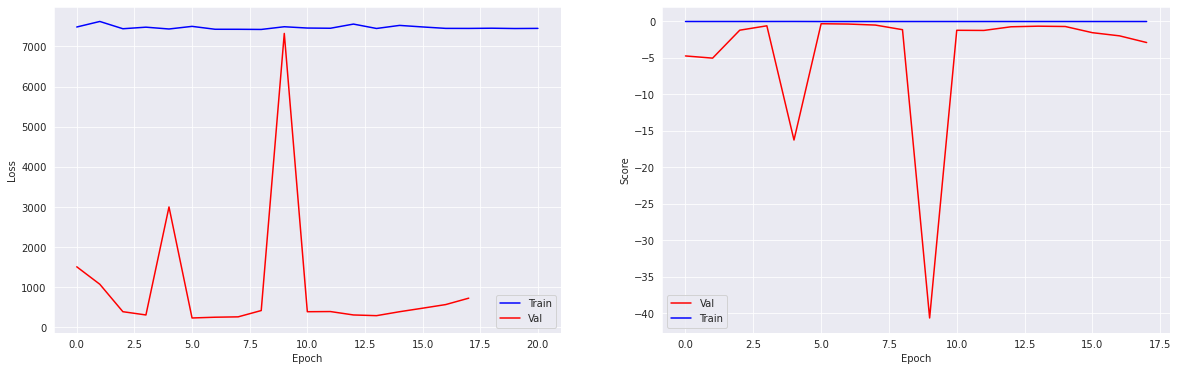

2021-01-14, Test loss: 12681.1845, test score: -0.0546


In [48]:
import datetime
# loss_fn = nn.HuberLoss(delta=50).to(device)
loss_fn = nn.MSELoss().to(device)
model = None


ds = torch.load('datasets/mean.dat')

train_loader, val_loader, test_loader = make_dataloaders_from_datasets(*make_datasets(ds), batch_size=128)
train_batches = [batch for batch in train_loader]
train_nodes = [n for batch in train_batches for n in batch[0]]
train_targets = torch.cat([batch[1] for batch in train_batches])
    
if model is None:
    model = Estimator(pyg_graph, train_nodes, train_targets).to(device)
else:
    model.set_observations(train_nodes, train_targets)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

model = train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=20, plotting=True)
test_loss, test_score = test(model, test_loader, loss_fn, device)
print(f'{day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

In [49]:
# ds = torch.load('datasets/mean.dat')
print(test(model, test_loader, loss_fn, device))
# kek = set()
for (x1, y1, x2, y2) in test_loader:
    print(torch.max(torch.exp(model(x1, x2)).detach().cpu()))
    print((y1 + 1) / (y2 + 1))

    # break


(12782.05992427916, -0.05460212414496923)
tensor(1.4750e+18)
tensor([2.9422e+00, 2.8969e+00, 5.6135e+00, 1.3201e+00, 3.5338e-01, 2.0294e+02,
        2.5785e-01, 4.8996e+00, 2.6805e+00, 1.0176e+00, 1.0000e+00, 2.0531e-02,
        1.3304e+00, 4.9277e-03, 7.8476e-01, 4.6466e-03, 1.2815e+00, 1.0946e+00,
        9.8011e-01, 1.0073e+00, 3.1800e-03, 6.5247e-01, 4.3934e-01, 9.4658e-01,
        3.6790e+00, 7.1817e-01, 3.4446e+00, 2.6246e-01, 3.8284e+02, 1.0650e+00,
        1.3833e+00, 1.2645e-01, 6.3505e-03, 2.1648e-01, 1.0732e+01, 1.2878e-01,
        1.3790e+00, 3.4516e+00, 2.0123e-02, 5.5166e+00, 2.3610e+00, 1.3465e+00,
        4.5093e+00, 3.5387e+00, 2.4588e+00, 3.2713e+00, 2.8972e-01, 8.8050e-02,
        6.0836e-01, 2.0324e+00, 3.2629e+00, 1.5225e+02, 1.7315e+00, 2.6831e+00,
        2.5813e+00, 2.7681e-03, 3.0038e-01, 2.3695e+00, 1.3889e+00, 1.1686e+00,
        4.8456e-03, 1.6691e-02, 5.4297e+00, 3.8782e+00, 1.0000e+00, 7.6997e-02,
        1.3924e+00, 3.7704e+00, 2.2151e-01, 2.0864e-01, 5.2

In [64]:
for name, param in model.named_parameters():
    print(name, torch.max(param))

loc_scaler.layers.0.weight tensor(0.6316, device='cuda:0', grad_fn=<MaxBackward1>)
loc_scaler.layers.0.bias tensor(0.2524, device='cuda:0', grad_fn=<MaxBackward1>)
loc_scaler.layers.2.weight tensor(1.1352, device='cuda:0', grad_fn=<MaxBackward1>)
loc_scaler.layers.2.bias tensor(0.1158, device='cuda:0', grad_fn=<MaxBackward1>)
